In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
class Vector(object):

    def __init__(self, start, end):
        self.start = start
        self.end = end
        self.centroid = (start + end) / 2
        
    def __sub__(self, other):
        return Vector(self.end, other.start)
    
    def intersects(self, other):
        # check if two vectors intersect
        return self.start <= other.end and other.start <= self.end
    
    # def __getitem__(self, key):
    #     if key == 0:
    #         return (self.start, self.end)
    #     else:
    #         raise IndexError('Index out of range')
    
    def __len__(self):
        return self.end - self.start
    
    def __str__(self):
        return f'({self.start}, {self.end})'

In [32]:
df = pd.read_csv('../datasets/fluencybank/csv/test/reading_test.csv')
df['annotations'] = df.iloc[:, 2:].apply(lambda row: [Vector(row[0], row[1]), row[2:-1], [row[-1]]], axis=1)
df = df['media_file anotator annotations'.split()]
df_ann = df[df['anotator']!='Gold']
df_gold = df[df['anotator']=='Gold'] 
df.head()

/var/folders/rq/nx9pwm754tz2tlk1z23n3q2c0000gn/T/ipykernel_21702/4294128723.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['annotations'] = df.iloc[:, 2:].apply(lambda row: [Vector(row[0], row[1]), row[2:-1], [row[-1]]], axis=1)


,media_file,anotator,annotations
0,50fb.wav,A1,"[(9267, 9597), [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,50fb.wav,A1,"[(10096, 10738), [0, 0, 0, 0, 1, 0, 0, 0, 0, 0..."
2,50fb.wav,A1,"[(12176, 19803), [0, 0, 0, 0, 0, 0, 0, 1, 1, 0..."
3,50fb.wav,A1,"[(28352, 41588), [0, 0, 0, 0, 0, 0, 0, 1, 0, 0..."
4,50fb.wav,A1,"[(42352, 48470), [0, 1, 0, 0, 0, 0, 0, 1, 0, 0..."


In [33]:
#  define Distance functions

def iou(a:Vector, b: Vector):
    intersection = max(0, min(a.end, b.end) - max(a.start, b.start))
    union = len(a) + len(b) - intersection
    return intersection / union

def iou_multiple(vas, vbs):
    return np.mean([iou(va, vb) for va in vas for vb in vbs])

def normalized_hamming_distance(label1, label2):
    differences = sum(1 for l1, l2 in zip(label1, label2) if l1 != l2)
    hamming_distance = differences / len(label1)
    return hamming_distance

def normalized_ordinal_distance(ordinal1, ordinal2, max_value=3):
    ordinal_distance = abs(ordinal1 - ordinal2) / max_value
    return ordinal_distance

def normalized_ordinal_distance_multiple(ordinal1s, ordinal2s, max_value):
    return np.mean([normalized_ordinal_distance(o1, o2) for o1 in ordinal1s for o2 in ordinal2s])

def normalized_hamming_distance_multiple(labels1, labels2):
    return np.mean([normalized_hamming_distance(l1, l2) for l1 in labels1 for l2 in labels2])

def score(row1, row2, weights=(0.33, 0.33, 0.34)):
    iou_score = iou(row1[0], row2[0])
    hamming_score = normalized_hamming_distance(row1[1], row2[1])
    ordinal_score = normalized_ordinal_distance(row1[2], row2[2], 3)
    return sum([iou_score * weights[0], hamming_score * weights[1], ordinal_score * weights[2]])

def score_multiple(row1, row2):
    return np.mean([score(r1, r2) for r1 in row1 for r2 in row2])




In [39]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import euclidean_distances
from collections import defaultdict
import copy

def unionize_vectorrange_sequence(vectorranges):
    min_s = min([vr.start for vr in vectorranges])
    max_e = max([vr.end for vr in vectorranges])
    return Vector(min_s, max_e)

def fragment_by_overlaps(annodf, uid_colname, item_colname, label_colname, decomp_fn, dist_fn=None, gold_df=None):
    resultdfs = []
    for item_id in annodf[item_colname].unique():
        idf = annodf[annodf[item_colname] == item_id]
        vectorranges = [vas[0] for vas in idf[label_colname]]

        regions = decomp_fn(vectorranges, dist_fn=dist_fn)
        origItemID = []
        newItemID = []
        newItemVR = []
        uid = []
        label = []
        gold = []
        for region in regions:
            for i, row in idf.iterrows():
                if region.intersects(row[label_colname][0]):
                    origItemID.append(item_id)
                    newItemID.append(F"{item_id}-{region}")
                    newItemVR.append(region)
                    uid.append(row[uid_colname])
                    label.append(row[label_colname])
                    if gold_df is not None:
                        # get the gold label that intersects with the region
                        gold_label = [vr for vr in gold_df[(gold_df[item_colname] == item_id) & (gold_df[uid_colname] == row[uid_colname])][label_colname].values[0] if region.intersects(vr)]
                        gold.append(gold_label)
                    else:
                        gold.append(None)
        resultdfs.append(pd.DataFrame({"origItemID":origItemID, "newItemID":newItemID, "newItemVR":newItemVR, uid_colname:uid, label_colname:label, "gold":gold}))
    return pd.concat(resultdfs)

def test_decomp_fn(vectorranges, use_centroids=True, dist_fn=None):

    if use_centroids:
        centroids = np.array([vr.centroid for vr in vectorranges]).reshape(-1, 1)
        # dists = euclidean_distances(centroids)
        # mean_dist = np.std(dists)
        mean_dist = 1000
        clustering = AgglomerativeClustering(n_clusters=None,
                                             distance_threshold=mean_dist)
        clustering.fit(centroids)
    else:
        dists = np.array([[1 - iou(a, b) for a in vectorranges] for b in vectorranges])
        mean_dist = np.std(dists)
        clustering = AgglomerativeClustering(n_clusters=None,
                                             distance_threshold=mean_dist,
                                             affinity="precomputed",
                                             linkage="average")
        clustering.fit(dists)
        
    labels = clustering.labels_
    labeldict = defaultdict(list)
    for i, label in enumerate(labels):
        labeldict[label].append(i)
    result = []
    for indices in labeldict.values():
        uv = unionize_vectorrange_sequence(np.array(vectorranges)[np.array(indices)])
        result.append(uv)

    return result

grannodf = fragment_by_overlaps(df_ann, "anotator", "media_file", "annotations", test_decomp_fn)
grannodf.head()

,origItemID,newItemID,newItemVR,anotator,annotations,gold
0,50fb.wav,"50fb.wav-(9267, 9597)","(9267, 9597)",A1,"[(9267, 9597), [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",None
1,50fb.wav,"50fb.wav-(10050, 10738)","(10050, 10738)",A1,"[(10096, 10738), [0, 0, 0, 0, 1, 0, 0, 0, 0, 0...",None
2,50fb.wav,"50fb.wav-(10050, 10738)","(10050, 10738)",A2,"[(10050, 10550), [0, 0, 0, 0, 1, 0, 0, 0, 0, 1...",None
3,50fb.wav,"50fb.wav-(11710, 19850)","(11710, 19850)",A1,"[(12176, 19803), [0, 0, 0, 0, 0, 0, 0, 1, 1, 0...",None
4,50fb.wav,"50fb.wav-(11710, 19850)","(11710, 19850)",A2,"[(12470, 19020), [0, 0, 0, 0, 0, 0, 0, 1, 1, 0...",None


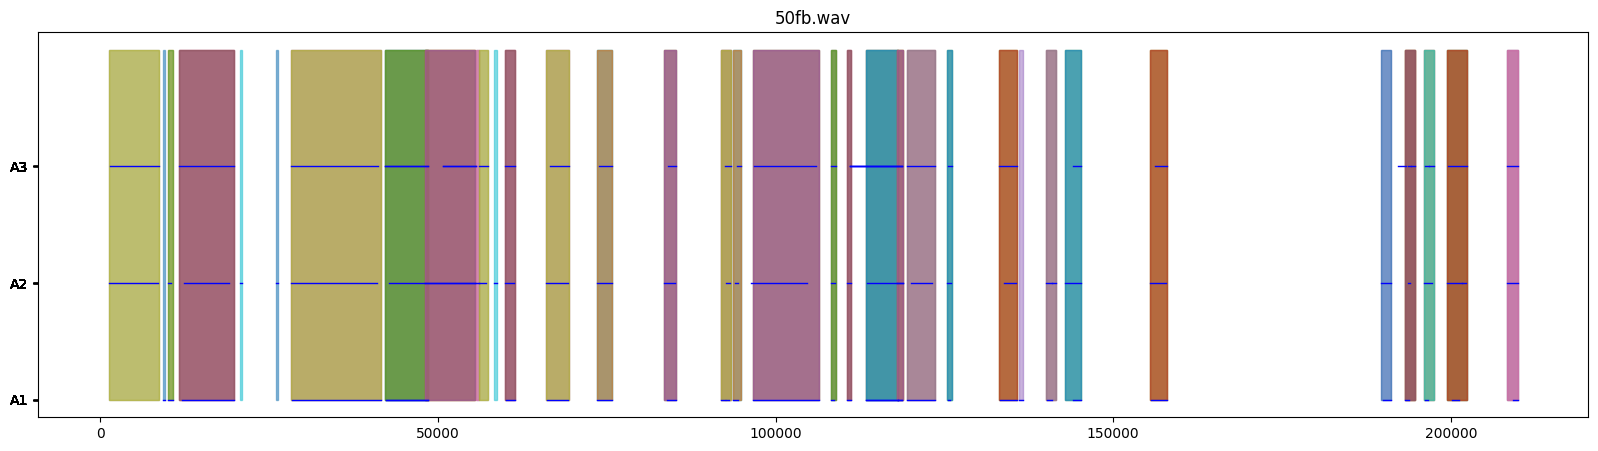

/var/folders/rq/nx9pwm754tz2tlk1z23n3q2c0000gn/T/ipykernel_21702/2044653538.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grannodf.iloc[:100].groupby('origItemID').apply(plot_ann)


""


In [57]:
# visualize groupings
from matplotlib.patches import Rectangle
def plot_vectorranges(vr,y, color='b', linewidth=1, alpha=1):
    plt.plot([vr.start, vr.end], y, color=color, linewidth=linewidth, alpha=alpha)

def plot_ann(data):
    vrs = [va[0] for va in data['annotations']]
    ys = [i for i in data['anotator_id']]
    unique_items = data['newItemID'].unique()

    # colors = sns.color_palette('tab10', n_colors=len(unique_items))

    fig, ax = plt.subplots(figsize=(20, 5))
    for vr, y in zip(vrs, ys):
        plot_vectorranges(vr, [y,y])

    colors = sns.color_palette('tab10', n_colors=len(unique_items))
    # plot the groupings
    for i,vr in enumerate(data['newItemVR']):
        color = i % len(colors)
        ax.add_patch(Rectangle((vr.start, 0), len(vr), 3, alpha=0.5, color=colors[color]))

    plt.yticks(ys, data['anotator'])
    plt.title(data['origItemID'].values[0])
    plt.show()

grannodf['anotator_id'] = grannodf['anotator'].astype('category').cat.codes
grannodf.iloc[:100].groupby('origItemID').apply(plot_ann)